# LDA - Fully Unsupervised

In [12]:
import warnings; warnings.simplefilter('ignore')
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import pyLDAvis, pyLDAvis.sklearn; pyLDAvis.enable_notebook()
import gensim, numpy as np, math
from unidecode import unidecode
from html import unescape
from textblob import TextBlob
from tqdm import tqdm
from lda import guidedlda
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

sns.set(style="ticks", color_codes=True)
random_state = 0

"Done"

'Done'

In [2]:
def get_umass_score(dt_matrix, i, j):
    zo_matrix = (dt_matrix > 0).astype(int)
    col_i, col_j = zo_matrix[:, i], zo_matrix[:, j]
    col_ij = col_i + col_j
    col_ij = (col_ij == 2).astype(int)    
    Di, Dij = col_i.sum(), col_ij.sum()    
    return math.log((Dij + 1) / Di)

def get_topic_coherence(dt_matrix, topic, n_top_words):
    indexed_topic = zip(topic, range(0, len(topic)))
    topic_top = sorted(indexed_topic, key=lambda x: 1 - x[0])[0:n_top_words]
    coherence = 0
    for j_index in range(0, len(topic_top)):
        for i_index in range(0, j_index - 1):
            i = topic_top[i_index][1]
            j = topic_top[j_index][1]
            coherence += get_umass_score(dt_matrix, i, j)
    return coherence

def get_average_topic_coherence(dt_matrix, topics, n_top_words):
    total_coherence = 0
    for i in range(0, len(topics)):
        total_coherence += get_topic_coherence(dt_matrix, topics[i], n_top_words)
    return total_coherence / len(topics)

In [3]:
try:
    fData = 'data/data_clean_TopicModelling.csv'
    df = pd.read_csv(fData)
    fData = 'data/lexicon-ipoleksosbudhankam.csv'
    dfL = pd.read_csv(fData)
except Exception as err_:    
    print(err_)
    print("Wajib menjalankan 'Sentimen_Analisis_Data_PreProcessing.ipynb' terlebih dahulu.")

print(df.shape)
print(df.info())
df[['cleaned_txt']].head(1)

(1349, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1349 entries, 0 to 1348
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   media        1349 non-null   object 
 1   judul        1349 non-null   object 
 2   berita       1349 non-null   object 
 3   date         669 non-null    object 
 4   url          669 non-null    object 
 5   Ideologi     1349 non-null   float64
 6   Politik      1349 non-null   float64
 7   Ekonomi      1349 non-null   float64
 8   Sosial       1349 non-null   float64
 9   Budaya       1349 non-null   float64
 10  Pertahanan   1349 non-null   float64
 11  Keamanan     1349 non-null   float64
 12  Olahraga     1349 non-null   float64
 13  Lainnya      1349 non-null   float64
 14  cleaned_txt  1349 non-null   object 
dtypes: float64(9), object(6)
memory usage: 158.2+ KB
None


,cleaned_txt
0,adnan arsal tebar damai indonesia. ketua maje...


In [71]:
seed_topic_list = {c.lower().strip():[] for c in dfL.columns}
for i, d in dfL.iterrows():
    for c in dfL.columns:
        if not pd.isna(d[c]) and not pd.isnull(d[c]):
            seed_topic_list[c.lower().strip()].append(unescape(unidecode(d[c])).lower().strip())
print(str(seed_topic_list)[:150])

nTopics = len(seed_topic_list)
nTopics

{'ideologi': ['pemikiran', 'aliran', 'ide', 'opini', 'gagasan', 'pendapat', 'pandangan', 'doktrin', 'mahzab', 'pedoman', 'dasar', 'fundamen', 'pandang


8

In [34]:
vsm = CountVectorizer(binary = False, ngram_range=(1, 3), min_df=1, max_df=1.0)

tf = vsm.fit_transform(df['cleaned_txt'])
tf_terms = vsm.get_feature_names_out()
word2id = dict((v, idx) for idx, v in enumerate(tf_terms))

print(tf.shape, type(tf))

(1349, 235172) <class 'scipy.sparse._csr.csr_matrix'>


In [58]:
lda_model = LDA(batch_size=100, doc_topic_prior=None,
                evaluate_every=-1, learning_decay=0.7,
                learning_method='batch', learning_offset=10.0,
                max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
                n_components=nTopics, n_jobs=-1, perp_tol=0.1,
                random_state=0, topic_word_prior=None,
                total_samples=1000000.0, verbose=0).fit(tf)

print("Log Likelihood LDA: ", lda_model.score(tf))

Log Likelihood LDA:  -9556656.336830875


In [59]:
# The lower UMass coherence - the better.
# https://stackoverflow.com/questions/69730428/how-do-i-find-coherence-score-for-lsa-and-lda-for-sklearn-models
n_top_words = 30
topics = lda_model.transform(tf)
coh_score = get_average_topic_coherence(tf, topics, n_top_words)
print("Coherence Score Fully Unsuervised LDA = ", coh_score)

Coherence Score =  -3.877807375141881


# Pemetaan Topik LDA ke Bidang di Seed

## Baris = Bidang Seed
## Kolom = Topik dari LDA

### Setiap baris dinormalisasi ke range [0,1]

In [93]:
print("Kata-kata di VSM ada sebanyak = ", len(vsm.get_feature_names_out()))
print("Ukuran matrix Topik X Kata = ", lda_model.components_.shape)
print("Menghitung probabilitas setiap topik ke Seed: ... ")
nTopics = lda_model.components_.shape[0]
nKata = lda_model.components_.shape[1]
id2word = {i:kata for i, kata in enumerate(vsm.get_feature_names_out())}
topicSeed = {bidang:[0.0]*nTopics for bidang in seed_topic_list.keys()}
for bidang in topicSeed.keys():
    for topic_ in range(nTopics):
        for j in range(nKata):
            if id2word[j] in seed_topic_list[bidang]:
                topicSeed[bidang][topic_] += lda_model.components_[topic_, j]
    range_ = np.sum(topicSeed[bidang])
    if range_>0.0:
        topicSeed[bidang] = [nilai/range_ for nilai in topicSeed[bidang]]
topicSeed = pd.DataFrame(topicSeed)
topicSeed.head(nTopics)   

Kata-kata di VSM ada sebanyak =  235172
Ukuran matrix Topik X Kata =  (8, 235172)
Menghitung probabilitas setiap topik ke Seed: ... 


,ideologi,politik,ekonomi,sosial,budaya,pertahanan,keamanan,olahraga
0,0.212912,0.162687,0.166329,0.169633,0.204846,0.239883,0.243704,0.178367
1,0.168877,0.178464,0.183860,0.099421,0.120926,0.164130,0.156738,0.089740
2,0.134998,0.174856,0.193731,0.190569,0.144799,0.125771,0.138848,0.150781
3,0.090552,0.075850,0.052775,0.131212,0.130172,0.089486,0.079945,0.052108
4,0.068480,0.069768,0.092862,0.089385,0.076343,0.067425,0.053378,0.126368
5,0.151854,0.151187,0.173026,0.138297,0.161029,0.147472,0.161006,0.163882
6,0.107362,0.095983,0.078700,0.114457,0.092946,0.104787,0.115549,0.161949
7,0.064966,0.091204,0.058717,0.067026,0.068940,0.061046,0.050831,0.076806


In [61]:
# melihat topik yang dominan pada tiap dokumen 
# Create Document - Topic Matrix
lda_output = lda_model.transform(tf)

# column names
topicnames = ["Topic" + str(i) for i in range(lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(df['cleaned_txt']))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 10), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(10).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,dominant_topic
Doc0,0.000199,0.000199,0.000199,0.000199,0.000199,0.000199,0.998606,0.000199,6
Doc1,0.000207,0.000207,0.000207,0.000207,0.000207,0.000207,0.000207,0.998550,7
Doc2,0.000107,0.000107,0.000107,0.000107,0.000107,0.999254,0.000107,0.000107,5
Doc3,0.000325,0.000325,0.000325,0.000325,0.000325,0.997725,0.000325,0.000325,5
Doc4,0.000157,0.000157,0.673156,0.000157,0.000157,0.325901,0.000157,0.000157,2
Doc5,0.997875,0.000304,0.000304,0.000304,0.000304,0.000304,0.000304,0.000304,0
Doc6,0.000494,0.000494,0.000494,0.000494,0.000494,0.996539,0.000494,0.000494,5
Doc7,0.999316,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0
Doc8,0.998450,0.000221,0.000221,0.000221,0.000221,0.000221,0.000221,0.000221,0
Doc9,0.000310,0.000310,0.000310,0.000310,0.720673,0.000310,0.000310,0.277465,4


In [62]:
# memaknai masing-masing topik dengan data frame
# Show top n keywords for each topic
def show_topics(vectorizer=vsm, lda_model=lda_model, n_words=10):
    keywords = np.array(vectorizer.get_feature_names_out())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vsm, lda_model=lda_model, n_words=10)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,indonesia,sulteng,ekonomi,tahun,masyarakat,kerja,perintah,laku,kota,tingkat
Topic 1,indonesia,tingkat,milu,besar,ekonomi,tahun,perintah,partai,kerja,menteri
Topic 2,masyarakat,indonesia,partai,ekonomi,sama,laku,perintah,sulteng,kerja,program
Topic 3,masyarakat,kerja,indonesia,desa,kabupaten,laku,ekonomi,poso,tahun,orang
Topic 4,program,tahun,kabupaten,daerah,laku,tingkat,masyarakat,kota,usaha,perintah
Topic 5,indonesia,sulteng,kerja,daerah,masyarakat,laku,perintah,ekonomi,sama,tengah
Topic 6,sulteng,indonesia,masyarakat,sama,kerja,tahun,laku,kota,besar,perintah
Topic 7,sulteng,tahun,daerah,indonesia,kota,ketua,partai,laku,kerja,perintah


,Topic Num,Num Documents
0,0,215
3,1,174
1,2,213
6,3,136
5,4,146
2,5,192
4,6,154
7,7,119


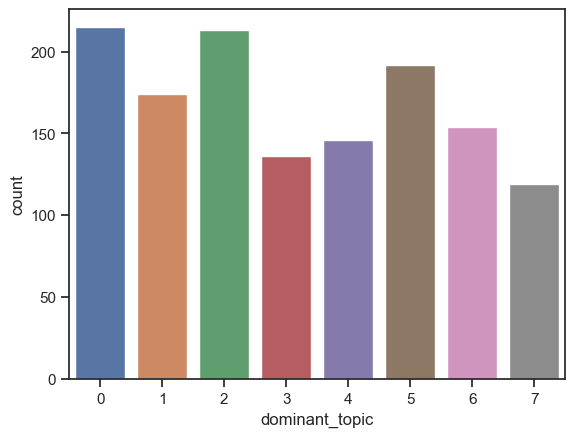

In [63]:
# melihat distribusi topik di seluruh dokumen 
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution.sort_values(by=['Topic Num'], inplace=True)
p = sns.countplot(x=df_document_topic['dominant_topic'])
df_topic_distribution

In [64]:
pyLDAvis.sklearn.prepare(lda_model, tf, vsm)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.079993  0.110013       1        1  17.793498
2      0.115568 -0.015940       2        1  15.160900
1      0.102629 -0.132367       3        1  14.443999
5     -0.059334  0.081948       4        1  14.140069
6     -0.019240  0.049193       5        1  10.790016
4     -0.124208 -0.105861       6        1  10.367294
3     -0.051629  0.018304       7        1   9.344501
7     -0.043779 -0.005289       8        1   7.959723, topic_info=               Term         Freq        Total Category  logprob  loglift
149585       partai  1150.000000  1150.000000  Default  30.0000  30.0000
202112      sulteng  2127.000000  2127.000000  Default  29.0000  29.0000
215979          tha   191.000000   191.000000  Default  28.0000  28.0000
162627         poso   486.000000   486.000000  Default  27.0000  27.0000
29967   bpjamsostek   278.000000   278.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
51566       ekonomi    84.594903  1801.789171   Topic8  -6.7155  -0.5279
213598       tengah    76.578055  1153.256957   Topic8  -6.8151  -0.1813
44173          desa    70.510569   818.716534   Topic8  -6.8977   0.0788
201498     sulawesi    70.354008   990.864725   Topic8  -6.8999  -0.1143
23759          beri    71.813688  1166.129821   Topic8  -6.8793  -0.2566

[704 rows x 6 columns], token_table=        Topic      Freq               Term
term                                      
184         2  0.932808        abdurrahman
185         2  0.932808  abdurrahman kasim
1158        8  0.975022            adjerni
1159        8  0.975022     adjerni sunusi
1649        1  0.109116              agama
...       ...       ...                ...
234630      3  0.918893              yondo
234630      5  0.079904              yondo
234633      3  0.897169       yondo pamona
234633      5  0.085445       yondo pamona
235068      1  0.987101              zuhro

[1597 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 6, 7, 5, 4, 8])

# Semi-Supervised LDA

In [65]:
from lda import guidedlda

"Done"

'Done'

In [73]:
allWords = vsm.get_feature_names_out().tolist()
word2id = {kata:i for i, kata in enumerate(vsm.get_feature_names_out())}
bidang = list(seed_topic_list.keys())

ideologi = [word2id[kata] for kata in allWords if kata in seed_topic_list['ideologi']]
politik = [word2id[kata] for kata in allWords if kata in seed_topic_list['politik']]
ekonomi = [word2id[kata] for kata in allWords if kata in seed_topic_list['ekonomi']]
sosial = [word2id[kata] for kata in allWords if kata in seed_topic_list['sosial']]
budaya = [word2id[kata] for kata in allWords if kata in seed_topic_list['budaya']]
pertahanan = [word2id[kata] for kata in allWords if kata in seed_topic_list['pertahanan']]
keamanan = [word2id[kata] for kata in allWords if kata in seed_topic_list['keamanan']]
olahraga = [word2id[kata] for kata in allWords if kata in seed_topic_list['olahraga']]

seed_list = [ideologi, politik, ekonomi, sosial, budaya, pertahanan, keamanan, olahraga]
print("Banyak kata di setiap bidang: ", [len(bidang) for bidang in seed_list])
print("Contoh 7 nilai index kata di bidang ideologi = ", ideologi[:7])

Banyak kata di setiap bidang:  [32, 41, 39, 28, 32, 26, 27, 34]
Contoh 7 nilai index kata di bidang ideologi =  [11821, 40000, 41140, 43028, 48738, 55332, 55703]


In [74]:
seed_topics = {}
for t_id, st in enumerate(seed_list):
    for idx in st:
        seed_topics[idx] = t_id

model_guided = guidedlda.GuidedLDA(n_topics=nTopics, n_iter=300, random_state=random_state, refresh=30)
model_guided.fit(tf, seed_topics=seed_topics, seed_confidence=0.95)

INFO:lda:n_documents: 1349
INFO:lda:vocab_size: 235172
INFO:lda:n_words: 876942
INFO:lda:n_topics: 8
INFO:lda:n_iter: 300
INFO:lda:<0> log likelihood: -12893636
INFO:lda:<30> log likelihood: -10170832
INFO:lda:<60> log likelihood: -9874276
INFO:lda:<90> log likelihood: -9769609
INFO:lda:<120> log likelihood: -9717471
INFO:lda:<150> log likelihood: -9695446
INFO:lda:<180> log likelihood: -9683586
INFO:lda:<210> log likelihood: -9677473
INFO:lda:<240> log likelihood: -9673383
INFO:lda:<270> log likelihood: -9670078
INFO:lda:<299> log likelihood: -9669070


In [77]:
print("Log Likelihood Guided LDA = ", max(model_guided.loglikelihoods_))

Log Likelihood Guided LDA =  -9670078.290506398


In [76]:
# The lower UMass coherence - the better.
# https://stackoverflow.com/questions/69730428/how-do-i-find-coherence-score-for-lsa-and-lda-for-sklearn-models
n_top_words = 30
topics = model_guided.transform(tf)
coh_score = get_average_topic_coherence(tf, topics, n_top_words)
print("Coherence Score Semi-Supervised LDA = ", coh_score)

Coherence Score Semi-Supervised LDA =  -3.731217151301803


# Pemetaan Topik Semi-Supervised LDA ke Bidang di Seed

## Baris = Bidang Seed
## Kolom = Topik dari LDA

### Setiap baris dinormalisasi ke range [0,1]

In [92]:
print("Kata-kata di VSM ada sebanyak = ", len(vsm.get_feature_names_out()))
print("Ukuran matrix Topik X Kata = ", model_guided.components_.shape)
print("Menghitung probabilitas setiap topik ke Seed: ... ")
nTopics = model_guided.components_.shape[0]
nKata = model_guided.components_.shape[1]
id2word = {i:kata for i, kata in enumerate(vsm.get_feature_names_out())}
topicSeed = {bidang:[0.0]*nTopics for bidang in seed_topic_list.keys()}
for bidang in topicSeed.keys():
    for topic_ in range(nTopics):
        for j in range(nKata):
            if id2word[j] in seed_topic_list[bidang]:
                topicSeed[bidang][topic_] += model_guided.components_[topic_, j]
    range_ = np.sum(topicSeed[bidang])
    if range_>0.0:
        topicSeed[bidang] = [nilai/range_ for nilai in topicSeed[bidang]]
topicSeed = pd.DataFrame(topicSeed)
topicSeed.head(nTopics)

Kata-kata di VSM ada sebanyak =  235172
Ukuran matrix Topik X Kata =  (8, 235172)
Menghitung probabilitas setiap topik ke Seed: ... 


,ideologi,politik,ekonomi,sosial,budaya,pertahanan,keamanan,olahraga
0,0.154861,0.069811,0.043738,0.127210,0.091754,0.086782,0.088707,0.048239
1,0.169272,0.320051,0.038334,0.071274,0.059327,0.106495,0.138597,0.078411
2,0.143223,0.154669,0.539893,0.110832,0.114610,0.188248,0.220157,0.042346
3,0.118884,0.095261,0.064656,0.284625,0.142818,0.101402,0.085668,0.059888
4,0.082928,0.064039,0.057618,0.123267,0.260136,0.068944,0.087577,0.068080
5,0.096124,0.081053,0.119128,0.142150,0.124474,0.130117,0.051414,0.090538
6,0.131888,0.143172,0.091360,0.084542,0.136620,0.255060,0.285032,0.061742
7,0.102819,0.071943,0.045272,0.056099,0.070260,0.062953,0.042847,0.550756


In [83]:
# melihat topik yang dominan pada tiap dokumen 
# Create Document - Topic Matrix
lda_output = model_guided.transform(tf)

# column names
topicnames = ["Topic" + str(i) for i in range(len(model_guided.components_))]

# index names
docnames = ["Doc" + str(i) for i in range(len(df['cleaned_txt']))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 10), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(10).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,dominant_topic
Doc0,0.082128,0.006840,0.000004,0.000006,0.325626,0.007867,0.577518,0.000010,6
Doc1,0.000009,0.016521,0.051956,0.000014,0.317196,0.289459,0.324835,0.000012,6
Doc2,0.030712,0.000008,0.080386,0.076712,0.000859,0.795544,0.015775,0.000004,5
Doc3,0.073125,0.000355,0.000013,0.357806,0.220077,0.000014,0.321271,0.027339,3
Doc4,0.000006,0.000010,0.000880,0.695120,0.000009,0.009446,0.016554,0.277976,3
Doc5,0.000006,0.889772,0.110167,0.000009,0.000012,0.000007,0.000021,0.000007,1
Doc6,0.000019,0.000025,0.000014,0.000027,0.000018,0.000027,0.000013,0.999857,7
Doc7,0.000007,0.000004,0.000006,0.000009,0.027376,0.000005,0.972587,0.000007,6
Doc8,0.000003,0.000003,0.000003,0.000004,0.999973,0.000005,0.000005,0.000003,4
Doc9,0.000003,0.999971,0.000003,0.000005,0.000004,0.000004,0.000005,0.000005,1


In [84]:
# memaknai masing-masing topik dengan data frame
# Show top n keywords for each topic
topic_keywords = show_topics(vectorizer=vsm, lda_model=model_guided, n_words=10)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,sulteng,masyarakat,hukum,buol,laku,kabupaten,gubernur,tha,haji,tengah
Topic 1,partai,milu,golkar,ketua,daerah,politik,indonesia,kota,kib,kerja
Topic 2,indonesia,ekonomi,menko,tingkat,perintah,menteri,tahun,kerja,besar,negara
Topic 3,kerja,masyarakat,kabupaten,bpjamsostek,sigi,perintah,sama,beri,program,sulawesi
Topic 4,poso,desa,masyarakat,agama,warga,laku,sulteng,uin,kabupaten,rumah
Topic 5,masyarakat,laku,layan,telkomsel,program,indonesia,cara,digital,tahun,langgan
Topic 6,indonesia,negara,tahun,ekonomi,sulteng,perintah,kasus,masyarakat,informasi,kerja
Topic 7,sulteng,kota,siswa,tahun,guru,ketua,sulawesi,laku,provinsi,tengah


,Topic Num,Num Documents
6,0,139
0,1,226
1,2,196
2,3,188
4,4,158
5,5,147
7,6,134
3,7,161


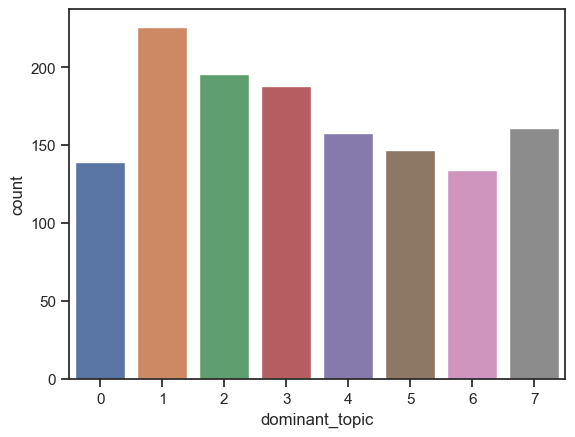

In [85]:
# melihat distribusi topik di seluruh dokumen 
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution.sort_values(by=['Topic Num'], inplace=True)
p = sns.countplot(x=df_document_topic['dominant_topic'])
df_topic_distribution

In [86]:
pyLDAvis.sklearn.prepare(model_guided, tf, vsm)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.270324  0.044697       1        1  18.227559
1     -0.020696  0.261010       2        1  14.952313
3     -0.002183 -0.059765       3        1  12.746830
7     -0.087034 -0.081560       4        1  11.917307
4     -0.066306 -0.179068       5        1  10.854133
6      0.094706  0.075992       6        1  10.632129
5      0.061986 -0.154596       7        1  10.421464
0     -0.250798  0.093291       8        1  10.248266, topic_info=            Term         Freq        Total Category  logprob  loglift
149585    partai  1422.000000  1422.000000  Default  30.0000  30.0000
51566    ekonomi  2206.000000  2206.000000  Default  29.0000  29.0000
131257      milu   819.000000   819.000000  Default  28.0000  28.0000
128315     menko  1053.000000  1053.000000  Default  27.0000  27.0000
61124     golkar   648.000000   648.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
154778  perintah   139.422679  1946.611933   Topic8  -6.4686  -0.3583
38093     daerah   134.548101  1573.869294   Topic8  -6.5042  -0.1813
197354      span   129.673523  1288.462239   Topic8  -6.5411  -0.0181
80274      jalan   121.874198   872.506612   Topic8  -6.6031   0.3097
64658       hari   119.924367   874.961778   Topic8  -6.6193   0.2907

[630 rows x 6 columns], token_table=        Topic      Freq         Term
term                                
1445        8  1.001150       aedega
1649        1  0.010058        agama
1649        2  0.030173        agama
1649        3  0.030173        agama
1649        4  0.158406        agama
...       ...       ...          ...
233544      1  0.989886          wto
233690      8  1.002194        wukuf
233919      2  0.993683        yahdi
233920      2  1.004890  yahdi basma
234315      3  0.985661        yatim

[1463 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 4, 8, 5, 7, 6, 1])

# Finish!